# Clean vs Noisy validation

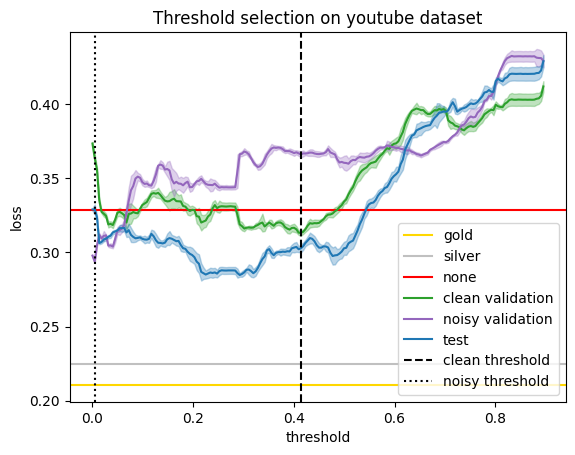

In [3]:
import os
import warnings
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

from mislabeled.datasets.wrench import fetch_wrench
from mislabeled.detect.detectors import AreaUnderMargin
from mislabeled.preprocessing import WeakLabelEncoder

seed = 42

dataset = "youtube"
fetch_wrench = partial(
    fetch_wrench,
    name=dataset,
    cache_folder=os.path.join(os.path.expanduser("~"), "datasets"),
)
all = fetch_wrench()
train = fetch_wrench(split="train")
validation = fetch_wrench(split="validation")
test = fetch_wrench(split="test")

tfidf = TfidfVectorizer(
    strip_accents="unicode", stop_words="english", min_df=5, max_df=0.5
).fit(all["data"])

X_train = tfidf.transform(train["data"]).astype(np.float32)
X_validation = tfidf.transform(validation["data"]).astype(np.float32)
X_test = tfidf.transform(test["data"]).astype(np.float32)

y_train = train["target"]
y_validation = validation["target"]
y_test = test["target"]

wle = WeakLabelEncoder(random_state=seed).fit(train["weak_targets"])
y_noisy_train = wle.transform(train["weak_targets"])
y_noisy_validation = wle.transform(validation["weak_targets"])
y_noisy_test = wle.transform(test["weak_targets"])

unlabeled = y_noisy_train == -1
unlabeled_val = y_noisy_validation == -1

classifier = SGDClassifier(
    loss="log_loss", learning_rate="constant", eta0=0.1, random_state=seed
)

n_runs = 10
n_splits = 200
splits = np.linspace(0, 0.9, endpoint=False, num=n_splits)

val_scores = np.empty((n_runs, n_splits))
noisy_val_scores = np.empty((n_runs, n_splits))
test_scores = np.empty((n_runs, n_splits))

gold_scores = np.empty(n_runs)
silver_scores = np.empty(n_runs)
none_scores = np.empty(n_runs)

for i in range(n_runs):
    classifier.set_params(random_state=seed + i)

    vosg = AreaUnderMargin(classifier)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        trust_scores = vosg.trust_score(X_train[~unlabeled], y_noisy_train[~unlabeled])

    gold_scores[i] = log_loss(
        y_test, classifier.fit(X_train, y_train).predict_proba(X_test)
    )

    clean = y_train == y_noisy_train
    silver_scores[i] = log_loss(
        y_test,
        classifier.fit(X_train[clean, :], y_noisy_train[clean]).predict_proba(X_test),
    )

    none_scores[i] = log_loss(
        y_test,
        classifier.fit(X_train[~unlabeled], y_noisy_train[~unlabeled]).predict_proba(
            X_test
        ),
    )

    for j, split in enumerate(splits):
        classifier.set_params(random_state=seed + i * n_splits + j)
        filtered = trust_scores >= np.quantile(trust_scores, split)
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning)
            classifier.fit(
                X_train[~unlabeled][filtered], y_noisy_train[~unlabeled][filtered]
            )
        val_scores[i, j] = log_loss(
            y_validation, classifier.predict_proba(X_validation)
        )
        noisy_val_scores[i, j] = log_loss(
            y_noisy_validation[~unlabeled_val],
            classifier.predict_proba(X_validation[~unlabeled_val]),
        )
        test_scores[i, j] = log_loss(y_test, classifier.predict_proba(X_test))


plt.axhline(np.mean(gold_scores), color="gold", label="gold")
plt.axhline(np.mean(silver_scores), color="silver", label="silver")
plt.axhline(np.mean(none_scores), color="red", label="none")
for scores, label, color in zip(
    (val_scores, noisy_val_scores, test_scores),
    ("clean validation", "noisy validation", "test"),
    ("green", "purple", "blue"),
):
    plt.plot(splits, np.mean(scores, axis=0), label=label, color=f"tab:{color}")
    plt.fill_between(
        splits,
        np.mean(scores, axis=0) + np.std(scores, axis=0),
        np.mean(scores, axis=0) - np.std(scores, axis=0),
        alpha=0.3,
        color=f"tab:{color}",
    )
plt.axvline(
    splits[np.argmin(np.mean(val_scores, axis=0))],
    linestyle="--",
    color="black",
    label="clean threshold",
)
plt.axvline(
    splits[np.argmin(np.mean(noisy_val_scores, axis=0))],
    linestyle=":",
    color="black",
    label="noisy threshold",
)
plt.xlabel("threshold")
plt.ylabel("loss")
plt.title(f"Threshold selection on {dataset} dataset")
plt.legend(loc="lower right")
plt.show()